In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

classical_electron_radius = 2.81794032e-15  # [m]
elec_rest_energy = 8.1871057880e-14  # [J]
MeV = 1.6022e-13  # [J]
barn = 1e-28  # [m2]
mol = 6.021e23  # [/mol]
material_number_density = 19320000 / 196.97 * mol * 79
alpha = 1/137
speed_of_light = 299792458
Z = 79
hbar = 1.054571817e-34


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


array([ 6.87223176, 12.96090964, 16.61736055])

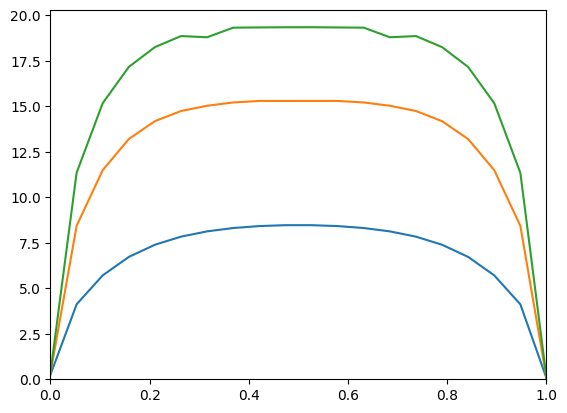

In [5]:
energy_gamma = np.linspace(5, 15, 3) * MeV
# energy_gamma = np.array([5, 10, 20]) * elec_rest_energy
# energy_elec = np.linspace(0, 100, 1000) * MeV
energy_elec_frac = np.linspace(0, 1, 20)
angle_posi = np.linspace(0, np.pi, 150)
angle_elec = np.linspace(0, np.pi, 150)
angle_inter = np.linspace(0, 2 * np.pi, 40)


def genarg(arg: npt.NDArray, axis: int) -> npt.NDArray:
    axes = {0, 1, 2, 3, 4} - {axis}
    arg = np.expand_dims(arg, axis=tuple(axes))
    for axis_i, size in [
        (i, x.size)
        for i, x in enumerate(
            # [energy_gamma, energy_elec, angle_posi, angle_elec, angle_inter]
            [energy_gamma, energy_elec_frac, angle_posi, angle_elec, angle_inter]
        )
        if i in axes
    ]:
        arg = arg.repeat(size, axis=axis_i)
    return arg


def d_(x: npt.NDArray) -> npt.NDArray:
    return x[1] - x[0]


def dsolid_dangle(a: npt.NDArray) -> npt.NDArray:
    return 2 * np.pi * np.sin(a)


def dsolid_dspherical(a: npt.NDArray) -> npt.NDArray:
    return np.sin(a)


# d_energy_elec = d_(energy_elec)
d_energy_elec_frac = d_(energy_elec_frac)
d_angle_posi = d_(angle_posi)
d_angle_elec = d_(angle_elec)
d_angle_inter = d_(angle_inter)

energy_gamma_ = genarg(energy_gamma, 0)
# energy_elec_ = genarg(energy_elec, 1)
energy_elec_ = (
    genarg(energy_elec_frac, 1) * (energy_gamma_ - (elec_rest_energy * 1.001) * 2)
    + elec_rest_energy * 1.0001
)
angle_posi_ = genarg(angle_posi, 2)
angle_elec_ = genarg(angle_elec, 3)
angle_inter_ = genarg(angle_inter, 4)

d_energy_elec = (
    d_energy_elec_frac
    * (energy_gamma_ - (elec_rest_energy * 1.001) * 2)
    # + elec_rest_energy * 1.0001
)

# E^2 = m^2 c^4 + p^2 c^2
# p^2 = (E^2 - E_rest^2)/c^2
Ey = energy_gamma_
En = energy_elec_
Ep = energy_gamma_ - energy_elec_
pn2 = ((En**2) - (elec_rest_energy**2)) / (speed_of_light**2)
pp2 = ((Ep**2) - (elec_rest_energy**2)) / (speed_of_light**2)
pn = np.sqrt(pn2)
pp = np.sqrt(pp2)

# k = Ey/c
k = energy_gamma_ / speed_of_light

# pnx = 0, ppx = -qx
# pny + ppy + qy = 0
# pnz + ppz + qz = k

# pnx = 0
# pny = |pn| sin(tn)
# pnz = |pn| cos(tn)
# ppx = |pp| sin(tp) sin(phi)
# ppy = |pp| sin(tp) cos(phi)
# ppz = |pn| cos(tp)

# p^2 =         pny^2 + pnz^2
# p^2 = ppx^2 + ppy^2 + ppz^2

pnx = 0
pny = pn * np.sin(angle_elec_)
pnR = pny
pnz = pn * np.cos(angle_elec_)
ppR = pp * np.sin(angle_posi_)
ppx = pp * np.sin(angle_posi_) * np.sin(angle_inter_)
ppy = pp * np.sin(angle_posi_) * np.cos(angle_inter_)
ppz = pp * np.cos(angle_posi_)
qx = -ppx
qy = -pny - ppy
qz = k - pnz - ppz
q2 = qx**2 + qy**2 + qz**2
q = np.sqrt(q2)
q4 = q2**2

c = speed_of_light
c2 = c * c
c4 = c2 * c2


# d_sigma = pn
d_sigma = (
    # (Z**2 * (hbar*c)**2 * alpha**3)
    (Z**2 * alpha * classical_electron_radius**2 * elec_rest_energy**2)
    / (2 * np.pi) ** 2
    * ((pp * pn) / (q4 * Ey**3))
    * (
        d_energy_elec
        * (dsolid_dangle(angle_elec_) * d_angle_elec)
        * (dsolid_dspherical(angle_posi_) * d_angle_posi * d_angle_inter)
    )
) * (
    -((pnR / (En - pnz * c)) ** 2) * (4 * Ep**2 - q2 * c2)
    - ((ppR / (Ep - ppz * c)) ** 2) * (4 * En**2 - q2 * c2)
    + 2
    / ((Ep - ppz * c) * (En - pnz * c))
    * ((ppR**2 + pnR**2) * (Ey**2) + (ppy * pny) * (2 * Ep**2 + 2 * En**2 - q2 * c2))
)
d_sigma[Ey - Ep - elec_rest_energy < 0] = 0
d_sigma[Ey - En - elec_rest_energy < 0] = 0
d_sigma[np.isnan(d_sigma)] = 0  #!!!!


plt.plot(
    # Ep[:, :, 0, 0, 0].transpose(),
    ((Ep - elec_rest_energy) / (Ey - 2 * elec_rest_energy))[:, :, 0, 0, 0].transpose(),
    # (d_sigma / barn).sum(axis=4).sum(axis=3).sum(axis=2).transpose(),
    ((d_sigma / d_energy_elec) * (Ey - 2 * elec_rest_energy) / barn)
    .sum(axis=(2,3,4))
    .transpose(),
)
# plt.plot(d_sigma.sum(axis=3).sum(axis=2).sum(axis=1).transpose())
# plt.xlabel("electron energy")
plt.xlim(0, 1)
plt.ylim(0, None)
d_sigma.sum(axis=(1, 2, 3, 4)) / barn

ok its now roughly correct, just a little high

In [86]:

s0 = 6.651e-29  # [m2]
a0 = (10*elec_rest_energy) / elec_rest_energy
csd_compton_total = (
    s0 * 3 / 8 / a0 * (np.log(2 * a0) + 0.5)
)

csd_compton_total/barn


np.float64(0.08718793256777847)

In [35]:
a = np.linspace(0,np.pi,100)
dangle = np.diff(a[:2])[0]

f = 1

np.sum(f * dsolid_dangle(a) * dangle), np.pi*4

(np.float64(12.565316069003892), 12.566370614359172)

In [62]:
a=(hbar*c)**2*(alpha**3)
b=alpha*classical_electron_radius**2*elec_rest_energy**2
b/a

0.999474672544398

3.8851144697888204e-58